# 

# Parte 02 - Prevendo a Retenção de Clientes com Dados Anônimos

## Modelagem


# 1.0 Instalando e Carregando Pacotes

In [1]:
import importlib    # Importa o módulo 'importlib', que permite importar bibliotecas dinamicamente em tempo de execução
import subprocess   # Importa o módulo 'subprocess' para executar comandos externos, como instalar pacotes via pip
import sys          # Importa o módulo 'sys' para acessar o interpretador Python atual e seu executável


# Dicionário contendo os pacotes que devem ser verificados e instalados, se necessário.
# A chave é o nome usado para importar o módulo, e o valor é o nome usado no pip para instalação.
required_packages = {
    'sklearn': 'scikit-learn',     # sklearn é importado como módulo, mas instalado com o nome scikit-learn
    'scipy': 'scipy',              # scipy é tanto o nome de importação quanto de instalação
    'pandas': 'pandas',            # pandas para análise de dados tabulares
    'numpy': 'numpy',              # numpy para operações numéricas
    'matplotlib': 'matplotlib',    # matplotlib para visualizações
    'seaborn': 'seaborn',          # seaborn para gráficos estatísticos
    'pickle': 'pickle'             # Importa a biblioteca pickle, usada para serialização e desserialização de objetos Python
}

# Função responsável por verificar se o pacote está instalado.
# Caso não esteja, ela o instala automaticamente usando pip.
def check_and_install(package_name, install_name):
    try:
        # Tenta importar o pacote. Se for bem-sucedido, ele já está instalado.
        importlib.import_module(package_name)
        print(f"✅ Biblioteca '{package_name}' já está instalada.")
    except ImportError:
        # Caso a importação falhe, significa que a biblioteca não está instalada.
        # O código abaixo usa o subprocess para executar o comando: python -m pip install <nome_do_pacote>
        print(f"⚠️ Biblioteca '{package_name}' não encontrada. Instalando '{install_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])
        print(f"✅ Biblioteca '{install_name}' instalada com sucesso.")

# Loop que percorre cada item do dicionário de pacotes.
# Para cada pacote, chama a função de verificação e instalação, se necessário.
for package, install_name in required_packages.items():
    check_and_install(package, install_name)

✅ Biblioteca 'sklearn' já está instalada.
✅ Biblioteca 'scipy' já está instalada.
✅ Biblioteca 'pandas' já está instalada.
✅ Biblioteca 'numpy' já está instalada.
✅ Biblioteca 'matplotlib' já está instalada.
✅ Biblioteca 'seaborn' já está instalada.
✅ Biblioteca 'pickle' já está instalada.


In [2]:
import pickle                                                                                       # Importa o módulo pickle para serialização e desserialização de objetos
import pandas as pd                                                                                 # Importa o pandas para manipulação de dados
import numpy as np                                                                                  # Importa o numpy para operações numéricas
import seaborn as sns                                                                               # Importa o seaborn para visualização de dados
import matplotlib.pyplot as plt                                                                     # Importa o matplotlib.pyplot para criação de gráficos
import xgboost as xgb                                                                               # Importa o xgboost para algoritmos de gradient boosting
import sklearn                                                                                      # Importa o scikit-learn para machine learning
from sklearn.preprocessing import StandardScaler                                                    # Importa StandardScaler para padronização de dados
from sklearn.linear_model import LogisticRegression                                                 # Importa LogisticRegression para regressão logística
from sklearn.naive_bayes import GaussianNB                                                          # Importa GaussianNB para o algoritmo Naive Bayes Gaussiano
from xgboost import XGBClassifier                                                                   # Importa XGBClassifier para classificação usando XGBoost
from sklearn.ensemble import RandomForestClassifier                                                 # Importa RandomForestClassifier para classificação usando Random Forest
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve # Importa métricas de avaliação de modelos
import warnings                                                                                     # Importa o módulo warnings para gerenciar alertas
warnings.filterwarnings('ignore')  

warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Ricardo de Souza Silva" 

Author: Ricardo de Souza Silva



# 2.0 Carregando os Dados

In [4]:
# Carrega o arquivo CSV 'dataset_treino.csv' localizado na pasta 'dados'
# O conteúdo do arquivo é lido e armazenado no DataFrame chamado 'dataset_treino'
dataset_treino = pd.read_csv("dados/dataset_treino.csv")

# Carrega o arquivo CSV 'dataset_teste.csv' da mesma forma
# O conteúdo é armazenado no DataFrame 'dataset_teste'
dataset_teste = pd.read_csv("dados/dataset_teste.csv")

# Carrega o arquivo CSV 'dataset_validacao.csv' localizado na pasta 'dados'
# O conteúdo é lido e armazenado no DataFrame 'dataset_validacao'
dataset_validacao = pd.read_csv("dados/dataset_validacao.csv")

# Carrega o arquivo CSV 'dataset_final_treino.csv'
# Corrigido o nome do arquivo, pois anteriormente estava escrito incorretamente como 'datset_final_treino'
# O conteúdo é armazenado no DataFrame 'dados_final_treino'
dados_final_treino = pd.read_csv("dados/dataset_final_treino.csv")

In [5]:
# Abre o arquivo 'colunas_entrada.sav' que está localizado na pasta 'dados'
# O modo "rb" significa "read binary" (leitura em modo binário), necessário para arquivos serializados com pickle
with open('dados/colunas_entrada.sav', "rb") as file:
    
    # Utiliza a função pickle.load() para desserializar o conteúdo do arquivo
    # O conteúdo original (possivelmente uma lista com os nomes das colunas de entrada) é carregado na variável 'colunas_entrada'
    colunas_entrada = pickle.load(file)

# 3.0 Preparando as Matrizes

## 3.1 Preparando os dados X

In [6]:
# Seleciona do DataFrame 'dados_final_treino' apenas as colunas especificadas na lista 'colunas_entrada'
# Em seguida, extrai apenas os valores (array NumPy) dessas colunas para treinar o modelo
dados_treino_x = dados_final_treino[colunas_entrada].values

# Faz o mesmo processo com o conjunto de validação: seleciona as colunas de entrada e extrai os valores
# Isso prepara os dados para serem usados na validação do modelo
dados_validacao_x = dataset_validacao[colunas_entrada].values

# Aplica o mesmo procedimento ao conjunto de teste: seleciona as colunas de entrada e extrai os valores
# OBS: havia um erro de digitação na palavra 'values' (estava escrito 'vallues')
dados_teste_x = dataset_teste[colunas_entrada].values


## 3.2 Preparando os dados Y

In [7]:
# Seleciona a coluna 'LABEL_TARGET' do DataFrame 'dados_final_treino'
# Essa coluna representa a variável alvo (target) para o modelo de machine learning
# Em seguida, extrai apenas os valores (array NumPy) dessa coluna
dados_treino_y = dados_final_treino['LABEL_TARGET'].values

# Repete o mesmo processo para o conjunto de validação
# Obtém os valores da variável alvo a partir do DataFrame 'dataset_validacao'
dados_validacao_y = dataset_validacao['LABEL_TARGET'].values

# E por fim, repete o procedimento para o conjunto de teste
# Extraindo os valores da variável alvo do DataFrame 'dataset_teste'
dados_teste_y = dataset_teste['LABEL_TARGET'].values


In [8]:
# Imprime o formato (shape) dos dados de treino
# 'dados_treino_x.shape' mostra o número de linhas (amostras) e colunas (variáveis de entrada)
# 'dados_treino_y.shape' mostra a quantidade de rótulos (targets), que deve ter o mesmo número de linhas que 'dados_treino_x'
print('Shape dos dados de treino:', dados_treino_x.shape, dados_treino_y.shape)      

# Imprime o formato dos dados de validação
# Serve para verificar se as dimensões das entradas e dos rótulos estão corretas e compatíveis
print('Shape dos dados de validação:', dados_validacao_x.shape, dados_validacao_y.shape)     

# Imprime o formato dos dados de teste
# Essa verificação é importante para garantir que os dados estão corretamente estruturados antes de treinar e avaliar o modelo
print('Shape dos dados de teste:', dados_teste_x.shape, dados_teste_y.shape)

Shape dos dados de treino: (3204, 178) (3204,)
Shape dos dados de validação: (1725, 178) (1725,)
Shape dos dados de teste: (1725, 178) (1725,)


# 4.0 Padronização dos Dados

In [9]:
# Cria um objeto da classe StandardScaler para realizar a padronização dos dados
# A padronização transforma os dados para que tenham média 0 e desvio padrão 1
padronizacao = StandardScaler()

# Ajusta o scaler (calculando média e desvio padrão) com base apenas nos dados de treino
# É importante usar apenas os dados de treino para evitar vazamento de informação (data leakage)
padronizacao.fit(dados_treino_x)

# Define o caminho onde o objeto padronizador será salvo
arquivo_padroniozado = 'dados/padronizador.sav'

# Salva o objeto padronizador em disco utilizando pickle no modo binário de escrita ('wb')
# Isso permite reutilizar a mesma padronização em outros momentos, como produção ou teste
pickle.dump(padronizacao, open(arquivo_padroniozado, 'wb'))

# Carrega o objeto padronizador salvo anteriormente a partir do arquivo
# Isso garante que a mesma transformação seja aplicada aos dados de validação e teste
padronizacao = pickle.load(open(arquivo_padroniozado, 'rb'))

# Aplica a padronização nos dados de treino
# Cada valor será transformado com base na média e desvio padrão aprendidos durante o fit
dados_treino_x_padronizados = padronizacao.transform(dados_treino_x)

# Aplica a padronização nos dados de validação
# Corrigido erro de digitação: 'trasnform' → 'transform'
dados_validacao_x_padronizados = padronizacao.transform(dados_validacao_x)

In [10]:
dados_treino_x_padronizados

array([[-0.41435084, -0.27979018, -0.13937869, ...,  1.05134599,
         1.08344249,  1.09495505],
       [ 0.22837261,  0.23491744,  0.19573262, ...,  0.05382072,
         0.06136262,  0.07841567],
       [-0.06637954, -0.13978971, -0.22734541, ..., -0.55690904,
        -0.54537006, -0.53557412],
       ...,
       [ 0.33481089,  0.3337413 ,  0.32139936, ...,  0.95362923,
         0.97756967,  0.87538255],
       [ 0.67459463, -0.56390878, -1.45887948, ...,  1.16942041,
         1.6820311 ,  1.9041204 ],
       [ 0.29796687,  0.35021195,  0.35909938, ..., -0.01132379,
        -0.11373473, -0.1736861 ]])

In [11]:
dados_validacao_x_padronizados

array([[-0.11141112, -0.09037777, -0.05141197, ..., -0.31668867,
        -0.1218788 ,  0.0662172 ],
       [ 0.51903099,  0.47785944,  0.19992151, ...,  0.00496234,
        -0.01600598,  0.02148946],
       [ 0.02368362, -0.01625988, -0.06816754, ...,  0.47318849,
         0.42377341,  0.38744364],
       ...,
       [-0.00906662,  0.06197568,  0.19573262, ..., -0.21897191,
        -0.2521838 , -0.28753851],
       [ 0.03596496,  0.03726972,  0.00304361, ...,  0.31847028,
         0.27310825,  0.2004004 ],
       [ 0.10555922,  0.12785826,  0.1538437 , ..., -0.07239676,
        -0.04043817, -0.02323827]])

# 5.0 Modelagem Preditiva

## 5.1 Funções Auxiliares

In [12]:
# Define uma função para calcular a especificidade de um modelo de classificação
# A especificidade mede a proporção de verdadeiros negativos entre todos os negativos reais
def calculo_de_especificidade(y_atual, y_preditivo, separador):
    
    # Conta quantas previsões foram verdadeiros negativos (preditivo < separador e valor real == 0)
    verdadeiros_negativos = sum((y_preditivo < separador) & (y_atual == 0))

    # Conta o total de casos negativos reais
    negativos_reais = sum(y_atual == 0)

    # Retorna a razão entre verdadeiros negativos e negativos reais, que é a definição de especificidade
    return verdadeiros_negativos / negativos_reais


---

A especificidade é uma métrica usada para avaliar o desempenho de um modelo de classificação, especialmente em problemas de classificação binária.

Ela mede a proporção de verdadeiros negativos (TN) em relação ao total de negativos reais, ou seja, a capacidade do modelo de identificar corretamente as instâncias negativas.

---

In [13]:
def relatorio_metricas(y_atual, y_preditivo, separador):
    
    # Calcula a métrica AUC (Área sob a Curva ROC), que mede a capacidade do modelo de separar as classes
    auc = roc_auc_score(y_atual, y_preditivo)                               
    # Calcula a acurácia: proporção de previsões corretas (True Positive + True Negative) sobre o total
    accuracy = accuracy_score(y_atual, (y_preditivo > separador))              
    # Calcula o recall (sensibilidade): proporção de positivos reais corretamente identificados
    recall = recall_score(y_atual, (y_preditivo > separador))                 
    # Calcula a precisão: proporção de positivos preditos que realmente são positivos
    precision = precision_score(y_atual, (y_preditivo > separador))           
    # Calcula a especificidade: proporção de negativos reais corretamente identificados 
    # (usando função personalizada externa chamada 'calculo_de_especificidade')
    specificity = calculo_de_especificidade(y_atual, y_preditivo, separador)  

    # Exibe a métrica AUC com três casas decimais
    print('AUC:%.3f' % auc)                     
    # Exibe a acurácia com três casas decimais
    print('Acurácia:%.3f' % accuracy)           
    # Exibe o recall com três casas decimais
    print('Recall:%.3f' % recall)               
    # Exibe a precisão com três casas decimais
    print('Precisão:%.3f' % precision)          
    # Exibe a especificidade com três casas decimais
    print('Especificidade:%.3f' % specificity)  
    # Imprime uma linha em branco para separar a saída
    print(' ')                                  
    # Retorna as métricas calculadas como uma tupla, podendo ser armazenadas ou usadas posteriormente
    return auc, accuracy, recall, precision, specificity  

# Define o valor de corte (threshold) para classificar os resultados como positivo ou negativo
separador = 0.5

# 6.0 Modelos - Definindo o Melhor Modelo

## 6.1 Modelo 01 - Regressão Logística Sem Otimização de Hiperparâmetros

In [14]:
# Instancia o modelo de Regressão Logística com os parâmetros padrão
regressao_logistica = LogisticRegression()

# Treina o modelo de regressão logística utilizando os dados de treino já padronizados
modelo_regressao_01 = regressao_logistica.fit(dados_treino_x_padronizados, dados_treino_y)

# Gera as probabilidades preditas para a classe positiva (1) no conjunto de treino
predicao_treino_y = modelo_regressao_01.predict_proba(dados_treino_x_padronizados)[:,1]

# Gera as probabilidades preditas para a classe positiva (1) no conjunto de validação
predicao_validacao_y = modelo_regressao_01.predict_proba(dados_validacao_x_padronizados)[:,1]

# Imprime o cabeçalho informando que se trata do modelo sem otimização de hiperparâmetros
print('Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)\n')

# Informa que as métricas a seguir são referentes ao conjunto de treino
print('Treinamento:\n')

# Chama a função que calcula e imprime as métricas de desempenho para o conjunto de treino
# As métricas retornadas são armazenadas em variáveis específicas
regressao_logistica_treino_auc, regressao_logistica__treino_accuracy, regressao_logistica__treino_recall, regressao_logistica__treino_precision, regressao_logistica__treinos_pecificity = relatorio_metricas(
    dados_treino_y,              # Valores reais do conjunto de treino
    predicao_treino_y,           # Probabilidades previstas para o conjunto de treino
    separador                    # Valor do threshold (limiar) de classificação
)

# Chama a função que calcula e imprime as métricas de desempenho para o conjunto de validação
# As métricas retornadas são armazenadas em variáveis específicas
regressao_logistica_validacao_auc, regressao_logistica__validacao_accuracy, regressao_logistica__validacao_recall, regressao_logistica__validacao_precision, regressao_logistica__validacao_pecificity = relatorio_metricas(
    dados_validacao_y,           # Valores reais do conjunto de validação
    predicao_validacao_y,        # Probabilidades previstas para o conjunto de validação
    separador                    # Valor do threshold (limiar) de classificação
)

Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)

Treinamento:

AUC:0.631
Acurácia:0.673
Recall:0.535
Precisão:0.739
Especificidade:0.811
 
AUC:0.505
Acurácia:0.717
Recall:0.413
Precisão:0.344
Especificidade:0.795
 


## 6.2 Modelo 02 - Regressão Logística Com Otimização de Hiperparâmetros

In [15]:
# Criação de um modelo de Regressão Logística com definição de semente (random_state)
# e escolha do solver 'liblinear' (bom para conjuntos pequenos e binários)
regressao_logistica_2 = LogisticRegression(random_state=142, solver='liblinear')

# Treinamento do modelo com os dados padronizados de entrada (X) e os rótulos (y)
modelo_regressao_02 = regressao_logistica_2.fit(dados_treino_x_padronizados, dados_treino_y)

# Geração das probabilidades preditas para a classe positiva (1) no conjunto de treino
predicao_treino_y = modelo_regressao_02.predict_proba(dados_treino_x_padronizados)[:, 1]

# Geração das probabilidades preditas para a classe positiva (1) no conjunto de validação
predicao_validacao_y = modelo_regressao_02.predict_proba(dados_validacao_x_padronizados)[:, 1]

# Impressão do cabeçalho indicando que este modelo teve otimização de hiperparâmetros
print('Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)\n')

# Seção de avaliação com métricas no conjunto de treinamento
print('Treinamento:\n')

# Chamada da função que calcula as métricas de avaliação no conjunto de treino,
# como AUC, acurácia, recall, precisão e especificidade
regressao_logistica_treino_auc_2, regressao_logistica__treino_accuracy_2, regressao_logistica__treino_recall_2, regressao_logistica__treino_precision_2, regressao_logistica__treinos_pecificity_2 = relatorio_metricas(
    dados_treino_y,               # Valores reais do conjunto de treino
    predicao_treino_y,            # Probabilidades previstas pelo modelo
    separador                     # Threshold de corte para classificar entre 0 e 1
)

# Cálculo das métricas de avaliação no conjunto de validação
regressao_logistica_validacao_auc_2, regressao_logistica__validacao_accuracy_2, regressao_logistica__validacao_recall_2, regressao_logistica__validacao_precision_2, regressao_logistica__validacao_pecificity_2 = relatorio_metricas(
    dados_validacao_y,            # Valores reais do conjunto de validação
    predicao_validacao_y,         # Probabilidades previstas no conjunto de validação
    separador                     # Threshold para converter probabilidade em classe
)

Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)

Treinamento:

AUC:0.634
Acurácia:0.675
Recall:0.537
Precisão:0.742
Especificidade:0.813
 
AUC:0.505
Acurácia:0.717
Recall:0.404
Precisão:0.342
Especificidade:0.798
 


## 6.3 Modelo 03 - Naive Bayes

In [16]:
# Instanciação do modelo Naive Bayes Gaussiano
naive_bayes = GaussianNB()

# Treinamento do modelo com os dados de treino já padronizados
modelo_naive_bayes = naive_bayes.fit(dados_treino_x_padronizados, dados_treino_y)

# Geração das probabilidades preditas para a classe positiva (1) no conjunto de treino
predicao_treino_y = modelo_naive_bayes.predict_proba(dados_treino_x_padronizados)[:, 1]

# Geração das probabilidades preditas para a classe positiva (1) no conjunto de validação
predicao_validacao_y = modelo_naive_bayes.predict_proba(dados_validacao_x_padronizados)[:, 1]

# Impressão do cabeçalho indicando o modelo utilizado
print('Modelo Naive Bayes\n')
print('Treinamento:\n')

# Cálculo das métricas de desempenho no conjunto de treino
naive_bayes_train_auc, naive_bayes_train_accuracy, naive_bayes_train_recall, naive_bayes_train_precision, naive_bayes_train_specificity = relatorio_metricas(
    dados_treino_y,           # Valores reais das classes no treino
    predicao_treino_y,        # Probabilidades previstas (devem ser do modelo Naive Bayes)
    separador                 # Threshold para converter probabilidades em classes
)

# Impressão do cabeçalho da validação
print('Validação:\n')

# Cálculo das métricas de desempenho no conjunto de validação
naive_bayes_valid_auc, naive_bayes_valid_accuracy, naive_bayes_valid_recall, naive_bayes_valid_precision, naive_bayes_valid_specificity = relatorio_metricas(
    dados_validacao_y,        # Valores reais das classes na validação
    predicao_validacao_y,     # Probabilidades previstas (devem ser do modelo Naive Bayes)
    separador                 # Threshold de decisão
)

Modelo Naive Bayes

Treinamento:

AUC:0.984
Acurácia:0.934
Recall:0.898
Precisão:0.968
Especificidade:0.971
 
Validação:

AUC:0.981
Acurácia:0.960
Recall:0.919
Precisão:0.891
Especificidade:0.971
 


## 6.4 Modelo 04 - XGBoost (Xtreme Gradient Boosting Classifier)

In [17]:
# Instancia o classificador XGBoost
xgboost = XGBClassifier()

# Treina o modelo XGBoost com os dados de treino já padronizados
modelo_xgboost = xgboost.fit(dados_treino_x_padronizados, dados_treino_y)

# Gera as probabilidades preditas da classe positiva (1) para os dados de treino
predicao_treino_y = modelo_xgboost.predict_proba(dados_treino_x_padronizados)[:, 1]

# Gera as probabilidades preditas da classe positiva (1) para os dados de validação
predicao_validacao_y = modelo_xgboost.predict_proba(dados_validacao_x_padronizados)[:, 1]

# Exibe o nome do modelo usado
print('Modelo Xtreme Gradient Boosting Classifier:\n')

print('Treinamento:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de treino
xgboost_train_auc, xgboost_train_accuracy, xgboost_train_recall, xgboost_train_precision, xgboost_train_specificity = relatorio_metricas(
    dados_treino_y,           # Rótulos reais do conjunto de treino
    predicao_treino_y,        # Probabilidades previstas pelo modelo para o treino
    separador                 # Threshold (limiar) para classificar como 0 ou 1
)

print('Validação:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de validação
xgboost_valid_auc, xgboost_valid_accuracy, xgboost_valid_recall, xgboost_valid_precision, xgboost_valid_specificity = relatorio_metricas(
    dados_validacao_y,        # Rótulos reais do conjunto de validação
    predicao_validacao_y,     # Probabilidades previstas pelo modelo para validação
    separador                 # Threshold (limiar) de decisão
)

Modelo Xtreme Gradient Boosting Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.961
Recall:0.944
Precisão:0.877
Especificidade:0.966
 


## 6.5 Modelo 05 - RandomForest

In [18]:
# Instancia o classificador Random Forest
classificador_floresta_aleatoria = RandomForestClassifier()

# Treina o modelo Random Forest com os dados de treino já padronizados
modelo_floresta_aleatoria = classificador_floresta_aleatoria.fit(dados_treino_x_padronizados, dados_treino_y)

# Gera as probabilidades preditas da classe positiva (1) para os dados de treino
predicao_treino_y = modelo_floresta_aleatoria.predict_proba(dados_treino_x_padronizados)[:, 1]

# Gera as probabilidades preditas da classe positiva (1) para os dados de validação
predicao_validacao_y = modelo_floresta_aleatoria.predict_proba(dados_validacao_x_padronizados)[:, 1]

# Exibe o nome do modelo usado
print('Modelo Random Forest Classifier:\n')

print('Treinamento:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de treino
classificador_floresta_aleatoria_train_auc, classificador_floresta_aleatoria_train_accuracy, classificador_floresta_aleatoria_train_recall, classificador_floresta_aleatoria_train_precision, classificador_floresta_aleatoria_train_specificity = relatorio_metricas(
    dados_treino_y,           # Rótulos reais do conjunto de treino
    predicao_treino_y,        # Probabilidades previstas pelo modelo para o treino
    separador                 # Threshold (limiar) para classificar como 0 ou 1
)

print('Validação:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de validação
classificador_floresta_aleatoria_valid_auc, classificador_floresta_aleatoria_valid_accuracy, classificador_floresta_aleatoria_valid_recall, classificador_floresta_aleatoria_valid_precision, classificador_floresta_aleatoria_valid_specificity = relatorio_metricas(
    dados_validacao_y,        # Rótulos reais do conjunto de validação
    predicao_validacao_y,     # Probabilidades previstas pelo modelo para validação
    separador                 # Threshold (limiar) de decisão
)

Modelo Random Forest Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.954
Recall:0.980
Precisão:0.827
Especificidade:0.944
 


# 7.0 Seleção de Modelos

In [19]:
# Criando o DataFrame df_results para armazenar métricas de desempenho dos classificadores
dados_resultado = pd.DataFrame({

    # Nome dos classificadores utilizados (Regressão Logística 1, Regressão Logística 2, Naive Bayes, XGBoost e Random Forest)
    'classificador': ['RL1', 'RL1', 'RL2', 'RL2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],  
    
    # Define se a linha corresponde aos resultados de treino ou de validação, repetindo para cada modelo
    'data_set': ['treino', 'valid'] * 5,  
    
    # Lista com os valores de AUC (Area Under the Curve) para cada modelo nos conjuntos de treino e validação
    'auc': [
        regressao_logistica_treino_auc,                    # RL1 - treino
        regressao_logistica_validacao_auc,                 # RL1 - validação
        regressao_logistica_treino_auc_2,                  # RL2 - treino
        regressao_logistica_validacao_auc_2,               # RL2 - validação
        naive_bayes_train_auc,                             # Naive Bayes - treino
        naive_bayes_valid_auc,                             # Naive Bayes - validação
        xgboost_train_auc,                                 # XGBoost - treino
        xgboost_valid_auc,                                 # XGBoost - validação
        classificador_floresta_aleatoria_train_auc,        # Random Forest - treino
        classificador_floresta_aleatoria_valid_auc         # Random Forest - validação
    ],
    
    # Lista com os valores de acurácia para cada modelo nos conjuntos de treino e validação
    'accuracy': [
        regressao_logistica__treino_accuracy,              # RL1 - treino
        regressao_logistica__validacao_accuracy,           # RL1 - validação
        regressao_logistica__treino_accuracy_2,            # RL2 - treino
        regressao_logistica__validacao_accuracy_2,         # RL2 - validação
        naive_bayes_train_accuracy,                        # Naive Bayes - treino
        naive_bayes_valid_accuracy,                        # Naive Bayes - validação
        xgboost_train_accuracy,                            # XGBoost - treino
        xgboost_valid_accuracy,                            # XGBoost - validação
        classificador_floresta_aleatoria_train_accuracy,   # Random Forest - treino
        classificador_floresta_aleatoria_valid_accuracy    # Random Forest - validação
    ],
    
    # Lista com os valores de recall (sensibilidade) para cada modelo nos conjuntos de treino e validação
    'recall': [
        regressao_logistica__treino_recall,                # RL1 - treino
        regressao_logistica__validacao_recall,             # RL1 - validação
        regressao_logistica__treino_recall_2,              # RL2 - treino
        regressao_logistica__validacao_recall_2,           # RL2 - validação
        naive_bayes_train_recall,                          # Naive Bayes - treino
        naive_bayes_valid_recall,                          # Naive Bayes - validação
        xgboost_train_recall,                              # XGBoost - treino
        xgboost_valid_recall,                              # XGBoost - validação
        classificador_floresta_aleatoria_train_recall,     # Random Forest - treino
        classificador_floresta_aleatoria_valid_recall      # Random Forest - validação
    ],
    
    # Lista com os valores de precisão (precision) para cada modelo nos conjuntos de treino e validação
    'precision': [
        regressao_logistica__treino_precision,             # RL1 - treino
        regressao_logistica__validacao_precision,          # RL1 - validação
        regressao_logistica__treino_precision_2,           # RL2 - treino
        regressao_logistica__validacao_precision_2,        # RL2 - validação
        naive_bayes_train_precision,                       # Naive Bayes - treino
        naive_bayes_valid_precision,                       # Naive Bayes - validação
        xgboost_train_precision,                           # XGBoost - treino
        xgboost_valid_precision,                           # XGBoost - validação
        classificador_floresta_aleatoria_train_precision,  # Random Forest - treino
        classificador_floresta_aleatoria_valid_precision   # Random Forest - validação
    ],
    
    # Lista com os valores de especificidade para cada modelo nos conjuntos de treino e validação
    'specificity': [
        regressao_logistica__treinos_pecificity,           # RL1 - treino
        regressao_logistica__validacao_pecificity,         # RL1 - validação
        regressao_logistica__treinos_pecificity_2,         # RL2 - treino
        regressao_logistica__validacao_pecificity_2,       # RL2 - validação
        naive_bayes_train_specificity,                     # Naive Bayes - treino
        naive_bayes_valid_specificity,                     # Naive Bayes - validação
        xgboost_train_specificity,                         # XGBoost - treino
        xgboost_valid_specificity,                         # XGBoost - validação
        classificador_floresta_aleatoria_train_specificity,# Random Forest - treino
        classificador_floresta_aleatoria_valid_specificity # Random Forest - validação
    ]
})

# O DataFrame df_results agora contém as principais métricas de desempenho para cada classificador,
# tanto nos dados de treino quanto nos dados de validação.
# Isso permite uma comparação direta entre os modelos em termos de capacidade preditiva e generalização.


In [20]:
dados_resultado

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL1,treino,0.631488,0.673221,0.534956,0.739431,0.811486
1,RL1,valid,0.504713,0.716522,0.412921,0.344262,0.795471
2,RL2,treino,0.633650,0.675094,0.536829,0.742019,0.813358
3,RL2,valid,0.505115,0.716522,0.404494,0.342043,0.797663
4,NB,treino,0.983586,0.934457,0.898252,0.968371,0.970662
5,NB,valid,0.981392,0.960000,0.918539,0.891008,0.970782
6,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB,valid,0.994195,0.961159,0.943820,0.877285,0.965668
8,RFC,treino,1.000000,1.000000,1.000000,1.000000,1.000000
9,RFC,valid,0.993781,0.953623,0.980337,0.827014,0.944485


---

**Análise Comparativa dos Classificadores**

Os resultados apresentados permitem uma comparação clara entre cinco modelos de classificação — **Regressão Logística 1 (RL1)**, **Regressão Logística 2 (RL2)**, **Naive Bayes (NB)**, **XGBoost (XGB)** e **Random Forest (RFC)** — avaliados tanto em conjunto de **treino** quanto de **validação**. As métricas utilizadas foram: **AUC**, **acurácia**, **recall**, **precisão** e **especificidade**.

🔹 Regressão Logística (RL1 e RL2)

Os modelos de regressão logística, tanto RL1 quanto RL2, apresentaram desempenho modesto. Em **validação**, o **AUC ficou próximo de 0.50**, o que indica um modelo com baixa capacidade discriminativa semelhante ao acaso. Apesar de manter uma acurácia próxima de 71%, o **recall foi baixo (em torno de 41%)**, o que mostra dificuldades em identificar corretamente as instâncias positivas. A **precisão** também foi baixa, refletindo incerteza nas previsões positivas.

🔹 Naive Bayes (NB)

O Naive Bayes mostrou um **excelente desempenho** em ambos os conjuntos. No treino, obteve **AUC de 0.98** e acurácia superior a 93%. Em validação, manteve um desempenho elevado com **AUC de 0.98**, **recall de 91.85%** e **especificidade de 97.07%**, sugerindo que o modelo está equilibrado tanto para detectar positivos quanto para evitar falsos positivos. Além disso, mesmo com uma leve queda de precisão, o modelo demonstrou boa **generalização**.

🔹 XGBoost (XGB)

O modelo XGBoost apresentou **overfitting** no conjunto de treino, com todas as métricas em **1.0**, ou seja, desempenho perfeito. Entretanto, em validação, houve uma queda esperada: **AUC de 0.99**, **acurácia de 96.12%** e **recall de 94.38%**, o que ainda é excelente. O modelo conseguiu manter uma **boa generalização**, apesar de ligeira perda de precisão (87.72%).

🔹 Random Forest (RFC)

A Random Forest também apresentou **overfitting** nos dados de treino, com métricas perfeitas. Em validação, o desempenho foi ligeiramente inferior ao XGBoost, com **AUC de 0.99**, acurácia de 95.36%, e um **recall superior (98.03%)**, o que é altamente desejável em aplicações onde falsos negativos são críticos. A **precisão de 82.70%** mostra um bom equilíbrio, mesmo em cenários de alta sensibilidade.

---

**Conclusão**

* **Modelos simples como Regressão Logística** não conseguiram capturar bem os padrões dos dados.
* **Naive Bayes** se destacou com desempenho elevado e consistente entre treino e validação.
* **XGBoost e Random Forest** foram os melhores modelos, mas com sinais de overfitting no treino. Ainda assim, **mantiveram ótimo desempenho em validação**, sendo ideais para uso em produção.
* A **escolha final** entre os modelos mais robustos deve considerar o contexto: se o objetivo for **maximizar o recall**, Random Forest é ligeiramente superior; se for buscar **equilíbrio entre as métricas**, o XGBoost apresenta resultados mais homogêneos.

---

In [21]:
# Filtra o DataFrame 'dados_resultado' para manter apenas as linhas em que a coluna 'data_set' é igual a 'valid'
# Isso seleciona os resultados referentes ao conjunto de validação (validação cruzada, hold-out, etc.)
dados_resultado[dados_resultado['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)
# Aplica ordenação ao resultado filtrado com base na coluna 'auc' (Area Under the Curve)
# 'ascending = False' indica que queremos ordenar do maior para o menor valor de AUC,
# ou seja, queremos ver primeiro os modelos com melhor desempenho de classificação

,classificador,data_set,auc,accuracy,recall,precision,specificity
7,XGB,valid,0.994195,0.961159,0.943820,0.877285,0.965668
9,RFC,valid,0.993781,0.953623,0.980337,0.827014,0.944485
5,NB,valid,0.981392,0.960000,0.918539,0.891008,0.970782
3,RL2,valid,0.505115,0.716522,0.404494,0.342043,0.797663
1,RL1,valid,0.504713,0.716522,0.412921,0.344262,0.795471


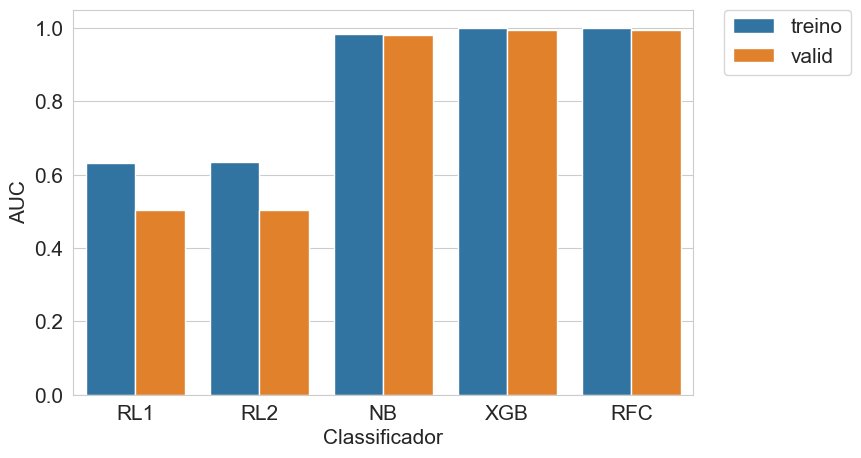

In [22]:
# Define o estilo visual dos gráficos com a grade branca de fundo (whitegrid)
# O seaborn ajusta automaticamente cores, grades e fontes com base nesse estilo
sns.set_style("whitegrid")

# Define o tamanho da figura do gráfico em polegadas (largura=8, altura=5)
# Isso controla o espaço disponível para os elementos visuais (barras, legendas, títulos)
plt.figure(figsize=(8, 5))

# Cria um gráfico de barras (barplot) usando seaborn
# Eixo x: nomes dos classificadores
# Eixo y: valores de AUC (area under the curve)
# hue='data_set' permite comparar subconjuntos (ex.: treino vs validação) com cores diferentes
# data=dados_resultado especifica o DataFrame de origem
ax = sns.barplot(x='classificador', y='auc', hue='data_set', data=dados_resultado)

# Define o rótulo do eixo x com o texto 'Classificador' e tamanho de fonte 15
ax.set_xlabel('Classificador', fontsize=15)

# Define o rótulo do eixo y com o texto 'AUC' e tamanho de fonte 15
ax.set_ylabel('AUC', fontsize=15)

# Define o tamanho dos números e rótulos nos eixos x e y
ax.tick_params(labelsize=15)

# Coloca a legenda fora do gráfico, à direita (bbox_to_anchor desloca a legenda)
# loc=2 indica posição "superior esquerda" relativa à âncora
# fontsize=15 ajusta o tamanho da fonte da legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)

# Exibe o gráfico na tela
plt.show()

# 8.0 Otimização de Hiperparâmetros e Validação Cruzada

---

Embora modelos preditivos possam apresentar resultados satisfatórios em uma avaliação inicial, isso não garante que estejam operando com seu desempenho ideal ou que generalizem bem para novos conjuntos de dados. Neste capítulo, exploramos a importância da validação cruzada e da otimização de hiperparâmetros como etapas fundamentais para o aprimoramento da performance dos modelos.

A validação cruzada permite uma avaliação mais robusta e confiável do desempenho, ao reduzir o viés que pode ocorrer quando se utiliza uma única partição dos dados para teste. Essa técnica distribui os dados entre múltiplos subconjuntos, garantindo que o modelo seja testado de forma mais equilibrada e representativa. Já a otimização de hiperparâmetros busca identificar a melhor combinação de parâmetros de controle que regem o funcionamento interno dos algoritmos, permitindo extrair o máximo potencial de cada modelo.

Mesmo quando os resultados iniciais são considerados bons, essas técnicas garantem que o modelo não esteja apenas ajustado aos dados observados, mas sim pronto para lidar com dados futuros de forma eficiente, confiável e com menor risco de overfitting ou underfitting. Portanto, validação cruzada e ajuste de hiperparâmetros são componentes indispensáveis em qualquer pipeline de modelagem estatística ou aprendizado de máquina.

---

In [23]:
# Importa a função GridSearchCV da biblioteca sklearn para busca de hiperparâmetros
from sklearn.model_selection import GridSearchCV

# Define o espaço de busca dos hiperparâmetros para o RandomForestClassifier
espaco_hiperparametro = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4]     # Número mínimo de amostras que devem estar presentes em um nó folha
}


In [24]:
# Cria o classificador com RandomForest
from sklearn.ensemble import RandomForestClassifier
classificador = RandomForestClassifier()

# Configura o GridSearchCV para buscar os melhores hiperparâmetros
melhores_hiperparametros = GridSearchCV(estimator=classificador, 
                           param_grid=espaco_hiperparametro, 
                           cv=5,                # Número de folds para validação cruzada
                           scoring='roc_auc',   # Métrica de avaliação: área sob a curva ROC
                           verbose=2,           # Nível de verbosidade
                           n_jobs=-1)           # Usa todos os processadores disponíveis

In [25]:
# Ajusta (treina) o modelo de floresta aleatória usando o GridSearchCV chamado 'melhores_hiperparametros'
# Isso executa a validação cruzada para cada combinação de hiperparâmetros definidos no param_grid
# Os dados de treino foram previamente padronizados para garantir que atributos em escalas diferentes
# não influenciem o modelo indevidamente (importante para muitos algoritmos)
modelo_floresta_aleatoria = melhores_hiperparametros.fit(dados_treino_x_padronizados, dados_treino_y)

# Após o ajuste, acessa os melhores hiperparâmetros encontrados pelo GridSearchCV
# .best_params_ retorna um dicionário com os valores de hiperparâmetros que produziram o melhor desempenho
print('Melhores hiperparâmetros:', melhores_hiperparametros.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [26]:
# Gera as probabilidades preditas da classe positiva (1) para os dados de treino
predicao_treino_y = modelo_floresta_aleatoria.predict_proba(dados_treino_x_padronizados)[:, 1]

# Gera as probabilidades preditas da classe positiva (1) para os dados de validação
predicao_validacao_y = modelo_floresta_aleatoria.predict_proba(dados_validacao_x_padronizados)[:, 1]

print('Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:\n')

print('Treinamento:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de treino
classificador_floresta_aleatoria_train_auc, classificador_floresta_aleatoria_train_accuracy, classificador_floresta_aleatoria_train_recall, classificador_floresta_aleatoria_train_precision, classificador_floresta_aleatoria_train_specificity = relatorio_metricas(
    dados_treino_y,           # Rótulos reais do conjunto de treino
    predicao_treino_y,        # Probabilidades previstas pelo modelo para o treino
    separador                 # Threshold (limiar) para classificar como 0 ou 1
)

print('Validação:\n')
# Calcula e imprime as métricas de desempenho do modelo nos dados de validação
classificador_floresta_aleatoria_valid_auc, classificador_floresta_aleatoria_valid_accuracy, classificador_floresta_aleatoria_valid_recall, classificador_floresta_aleatoria_valid_precision, classificador_floresta_aleatoria_valid_specificity = relatorio_metricas(
    dados_validacao_y,        # Rótulos reais do conjunto de validação
    predicao_validacao_y,     # Probabilidades previstas pelo modelo para validação
    separador                 # Threshold (limiar) de decisão
)

Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.955
Recall:0.978
Precisão:0.835
Especificidade:0.950
 


In [ ]:
# Importa o módulo 'os' que permite interagir com o sistema operacional,
# como verificar e criar pastas no sistema de arquivos.
import os

# Verifica se a pasta chamada 'modelos' já existe no diretório atual.
# Isso evita erro se tentarmos criar uma pasta que já está criada.
if not os.path.exists('modelos'):
    # Caso a pasta 'modelos' não exista, ela será criada automaticamente.
    os.makedirs('modelos')

In [32]:
# Salva (serializa) o objeto 'modelo_floresta_aleatoria' em um arquivo usando o módulo pickle.
# Esse processo transforma o modelo treinado em uma sequência de bytes para que ele possa ser armazenado em disco
# e reutilizado posteriormente, sem a necessidade de re-treinamento.

# A função 'open' é usada para abrir (ou criar) o arquivo chamado 'melhor_modelo.pkl' dentro da pasta 'modelos'.
# O modo 'wb' significa "write binary" (escrita em modo binário), necessário para salvar objetos com pickle.

# O parâmetro 'protocol=4' define o protocolo de serialização do pickle.
# O protocolo 4 é compatível com versões do Python a partir da 3.4 e é mais eficiente para objetos grandes.
pickle.dump(modelo_floresta_aleatoria, open('modelos/melhor_modelo.pkl', 'wb'), protocol=4)

# 9.0 Avaliação Final do Modelo

## 9.1 Carregando Dados

In [ ]:
# Carrega o modelo treinado salvo anteriormente com pickle.
# O arquivo 'melhor_modelo.pkl' está localizado na pasta 'modelos'.
# O modo 'rb' significa "read binary" (leitura em modo binário), necessário para deserializar com pickle.
melhor_modelo = pickle.load(open('modelos/melhor_modelo.pkl', 'rb'))

# Carrega a lista ou estrutura que contém os nomes das colunas utilizadas como entrada no modelo.
# Isso é importante para garantir que os dados novos estejam no mesmo formato que os dados usados no treinamento.
colunas_entrada = pickle.load(open('dados/colunas_entrada.sav', 'rb'))

# Carrega o objeto de normalização (por exemplo, um StandardScaler) que foi usado para padronizar os dados de entrada.
# É fundamental aplicar exatamente a mesma normalização nos dados novos para que o modelo funcione corretamente.
normalizacao_dados = pickle.load(open('dados/padronizador.sav', 'rb'))             

In [35]:
# Importa os dados de treino a partir do arquivo CSV localizado na pasta 'dados'.
# Este conjunto será utilizado para treinar o modelo ou para análises internas.
dados_treino = pd.read_csv("dados/dataset_final_treino.csv")

# Importa os dados de validação, também a partir da pasta 'dados'.
# O conjunto de validação é usado para avaliar o desempenho do modelo durante o ajuste,
# ajudando na escolha de hiperparâmetros e prevenção de overfitting.
dados_validacao = pd.read_csv('dados/dataset_validacao.csv')

# Importa os dados de teste finais, que devem ser mantidos separados do processo de modelagem.
# Esse conjunto é utilizado para avaliar o desempenho real do modelo em dados nunca vistos.
dados_teste = pd.read_csv('dados/dataset_teste.csv')

## 9.2 Criando Matrizes X e Y

In [36]:
# Seleciona apenas as colunas de entrada (features) do conjunto de dados de treino,
# com base na lista 'colunas_entrada' previamente carregada. 
# O método '.values' converte o DataFrame em um array NumPy, que é o formato esperado por muitos modelos.
x_treino = dados_treino[colunas_entrada].values

# Faz o mesmo para os dados de validação, garantindo que as mesmas colunas de entrada sejam usadas
# e na mesma ordem. Isso é crucial para manter a consistência do modelo.
x_validacao = dados_validacao[colunas_entrada].values

# Também aplica a mesma seleção de colunas aos dados de teste.
# Dessa forma, todos os conjuntos (treino, validação e teste) têm a mesma estrutura.
x_teste = dados_teste[colunas_entrada].values

In [ ]:
# Extrai a variável alvo (target) do conjunto de treino, que neste caso é a coluna 'LABEL_TARGET'.
# O método '.values' converte a coluna em um array NumPy para uso nos algoritmos de machine learning.
y_treino = dados_treino['LABEL_TARGET'].values

# Faz o mesmo para o conjunto de validação, garantindo que a variável alvo esteja separada
# para avaliação durante o ajuste e validação do modelo.
y_validacao = dados_validacao['LABEL_TARGET'].values

# E também para o conjunto de teste, que será usado para avaliar a performance final do modelo.
y_teste = dados_teste['LABEL_TARGET'].values

In [38]:
# Aplica o transformador de normalização (por exemplo, StandardScaler) nos dados de treino.
# Isso garante que todas as variáveis de entrada estejam na mesma escala (média 0, desvio padrão 1),
# utilizando os parâmetros (média e desvio) que foram ajustados no conjunto original de treino.
x_treino_padronizado = normalizacao_dados.transform(x_treino)

# Aplica a mesma transformação nos dados de validação.
# É importante usar o mesmo transformador para garantir consistência nos dados e evitar vazamento de dados.
x_validacao_padronizado = normalizacao_dados.transform(x_validacao)

# Também transforma os dados de teste com o mesmo padronizador.
# Isso garante que os dados usados para avaliar o modelo final estejam no mesmo formato dos dados de treino.
x_teste_padronizado = normalizacao_dados.transform(x_teste)

In [39]:
# Realiza a predição das probabilidades no conjunto de treino usando o modelo carregado.
# A função 'predict_proba' retorna uma matriz com duas colunas:
# - [:, 0] = probabilidade de pertencer à classe 0
# - [:, 1] = probabilidade de pertencer à classe 1 (classe positiva, geralmente o foco em classificação binária)
# Aqui, estamos selecionando apenas a segunda coluna, ou seja, a probabilidade da classe positiva.
y_predicao_treino = melhor_modelo.predict_proba(x_treino_padronizado)[:, 1]

# Faz o mesmo para o conjunto de validação, obtendo a probabilidade da classe 1.
# Essa probabilidade pode ser usada para avaliar o modelo com métricas como AUC, Precision-Recall, etc.
y_predicao_validacao = melhor_modelo.predict_proba(x_validacao_padronizado)[:, 1]

# E por fim, aplica a mesma predição no conjunto de teste, que representa os dados "reais" e finais para análise.
# Esses valores são cruciais para avaliar o desempenho do modelo antes de um possível deploy.
y_predicao_teste = melhor_modelo.predict_proba(x_teste_padronizado)[:, 1]

## 9.3 Avaliação Final

In [40]:
# Define o limiar (threshold) de classificação.
# Se a probabilidade prevista for >= 0.5, será considerada como classe 1 (positiva); caso contrário, classe 0.
separador = 0.5

# Impressão de cabeçalho para indicar que as métricas a seguir se referem ao conjunto de treino.
print('\nTreinamento:\n')

# Chama a função 'relatorio_metricas' passando os rótulos verdadeiros e as probabilidades previstas para o conjunto de treino.
# O separador é usado internamente para transformar as probabilidades em classes preditas (0 ou 1).
# A função retorna várias métricas de avaliação: AUC, Acurácia, Recall, Precisão e Especificidade.
classificador_floresta_aleatoria_train_auc, classificador_floresta_aleatoria_train_accuracy, classificador_floresta_aleatoria_train_recall, classificador_floresta_aleatoria_train_precision, classificador_floresta_aleatoria_train_specificity = relatorio_metricas(
    y_treino,              # Rótulos reais do treino
    y_predicao_treino,     # Probabilidades preditas pelo modelo
    separador              # Limiar de corte para converter probabilidade em classe
)

# Impressão de cabeçalho para indicar que agora as métricas serão do conjunto de validação.
print('Validação:\n')

# Repete o processo acima, agora com os dados de validação.
classificador_floresta_aleatoria_valid_auc, classificador_floresta_aleatoria_valid_accuracy, classificador_floresta_aleatoria_valid_recall, classificador_floresta_aleatoria_valid_precision, classificador_floresta_aleatoria_valid_specificity = relatorio_metricas(
    y_validacao,             # Rótulos reais da validação
    y_predicao_validacao,    # Probabilidades preditas pelo modelo
    separador                # Limiar de decisão
)

# Imprime o relatório de métricas no conjunto de teste
print('\nTeste:\n')
# Por fim, calcula as métricas de avaliação no conjunto de teste,
# que é usado para simular o desempenho real do modelo em produção.
classificador_floresta_aleatoria_test_auc, classificador_floresta_aleatoria_test_accuracy, classificador_floresta_aleatoria_test_recall, classificador_floresta_aleatoria_test_precision, classificador_floresta_aleatoria_test_specificity = relatorio_metricas(
    y_teste,               # Rótulos reais do teste
    y_predicao_teste,      # Probabilidades preditas
    separador              # Limiar para transformar probabilidade em classe
) 
        


Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.955
Recall:0.978
Precisão:0.835
Especificidade:0.950
 

Teste:

AUC:0.993
Acurácia:0.948
Recall:0.985
Precisão:0.800
Especificidade:0.937
 


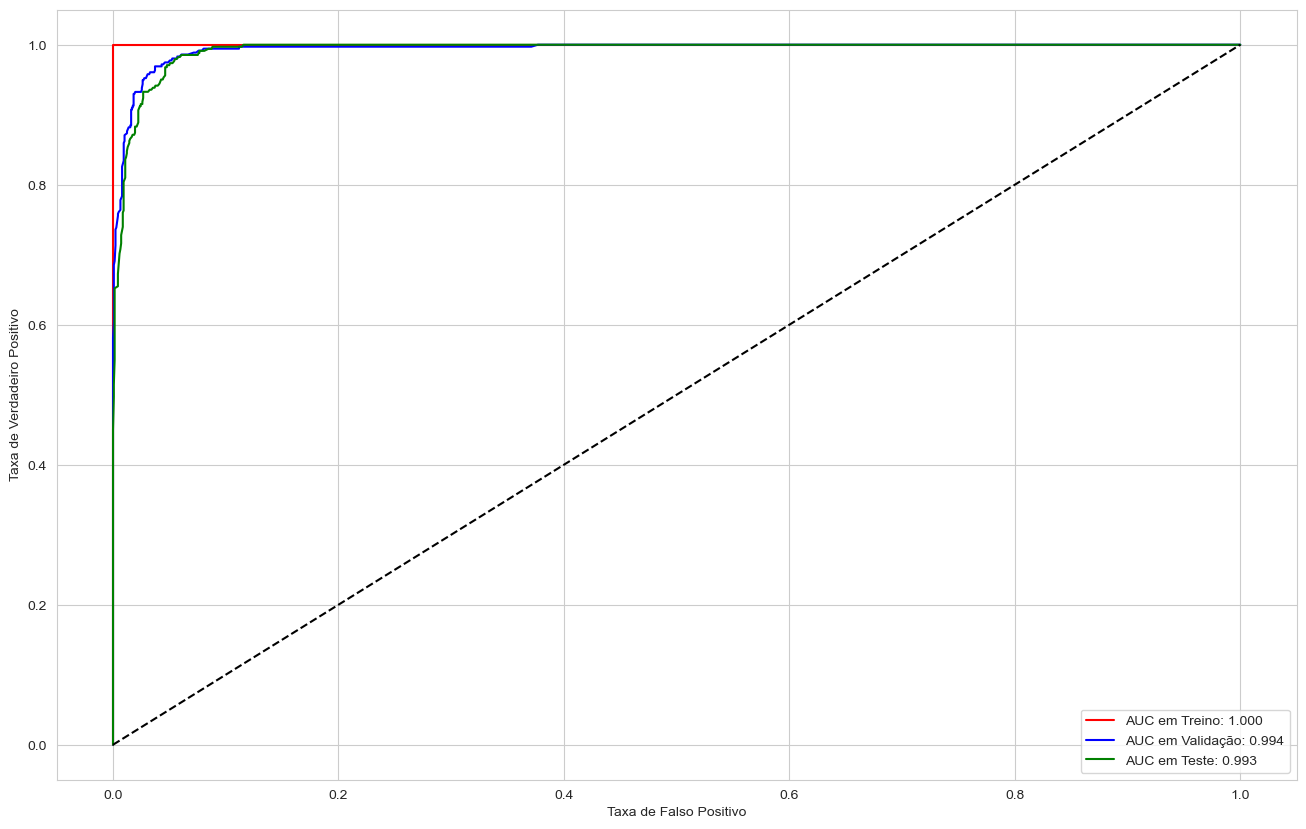

In [ ]:
# Importa a função 'roc_curve' para calcular a curva ROC
# e 'roc_auc_score' para calcular a área sob a curva ROC (AUC)
from sklearn.metrics import roc_curve, roc_auc_score

# Importa a biblioteca de visualização para plotar os gráficos
import matplotlib.pyplot as plt

# -----------------------------
# CÁLCULO DA CURVA ROC - TREINO
# -----------------------------

# Calcula a curva ROC no conjunto de treino.
# 'roc_curve' retorna 3 elementos:
# - fpr_train: taxa de falso positivo (False Positive Rate)
# - tpr_train: taxa de verdadeiro positivo (True Positive Rate)
# - thresholds_train: limiares de probabilidade para as classificações
fpr_train, tpr_train, thresholds_train = roc_curve(y_treino, y_predicao_treino)

# Calcula a área sob a curva ROC (AUC) para o conjunto de treino.
# A AUC varia de 0.5 (modelo aleatório) a 1 (classificação perfeita).
auc_train = roc_auc_score(y_treino, y_predicao_treino)

# --------------------------------
# CÁLCULO DA CURVA ROC - VALIDAÇÃO
# --------------------------------

# Aplica o mesmo processo de cálculo da curva ROC ao conjunto de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_validacao, y_predicao_validacao)

# Calcula a AUC para os dados de validação
auc_valid = roc_auc_score(y_validacao, y_predicao_validacao)

# ----------------------------
# CÁLCULO DA CURVA ROC - TESTE
# ----------------------------

# Calcula a curva ROC no conjunto de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_teste, y_predicao_teste)

# Calcula a AUC para o conjunto de teste
auc_test = roc_auc_score(y_teste, y_predicao_teste)

# -------------------------------
# PLOTAGEM DAS CURVAS ROC
# -------------------------------

# Cria uma nova figura com tamanho 16x10 polegadas para melhor visualização
plt.figure(figsize=(16, 10))

# Plota a curva ROC para o conjunto de treino com linha vermelha
plt.plot(fpr_train, tpr_train, 'r-', label='AUC em Treino: %.3f' % auc_train)

# Plota a curva ROC para o conjunto de validação com linha azul
plt.plot(fpr_valid, tpr_valid, 'b-', label='AUC em Validação: %.3f' % auc_valid)

# Plota a curva ROC para o conjunto de teste com linha verde
plt.plot(fpr_test, tpr_test, 'g-', label='AUC em Teste: %.3f' % auc_test)

# Plota a linha de referência (classificação aleatória), uma diagonal de 0 a 1
plt.plot([0, 1], [0, 1], 'k--')

# Define o rótulo do eixo X como "Taxa de Falso Positivo"
plt.xlabel('Taxa de Falso Positivo')

# Define o rótulo do eixo Y como "Taxa de Verdadeiro Positivo"
plt.ylabel('Taxa de Verdadeiro Positivo')

# Adiciona a legenda no gráfico, com as AUCs de cada conjunto
plt.legend()

# Exibe o gráfico na tela
plt.show()

---

### 📝 **Relatório – Avaliação do Modelo via Curva ROC**

A curva ROC (Receiver Operating Characteristic) é uma ferramenta essencial para avaliar o desempenho de modelos de classificação binária, especialmente quando se trabalha com diferentes limiares de decisão.

#### 🔍 **Resumo das AUCs**

* **Treinamento (AUC = 1.000)**
  O modelo apresenta desempenho perfeito no conjunto de treino, o que é um forte indicativo de **overfitting** — ou seja, ele pode ter memorizado os dados de treino em vez de aprender padrões generalizáveis.

* **Validação (AUC = 0.994)**
  Excelente desempenho no conjunto de validação, o que sugere que o modelo generalizou bem. A proximidade com a AUC de treino mostra que o modelo manteve boa capacidade preditiva em dados novos (durante o ajuste de hiperparâmetros, por exemplo).

* **Teste (AUC = 0.993)**
  A AUC no teste é quase idêntica à da validação, o que confirma que o modelo possui **alta capacidade de generalização** e estabilidade preditiva. Isso reforça que o modelo está bem ajustado e pronto para uso prático.

#### 📈 **Interpretação Gráfica**

* As curvas ROC de treino, validação e teste estão próximas do canto superior esquerdo do gráfico, o que é **ideal** e indica baixas taxas de falsos positivos e altas taxas de verdadeiros positivos.
* A linha pontilhada preta representa um classificador aleatório (AUC = 0.5). Como todas as curvas estão bem acima dela, temos evidência de que o modelo está fazendo boas distinções entre as classes.

---

### ✅ **Conclusão**

O modelo apresenta excelente desempenho em todos os conjuntos (treino, validação e teste), com **valores de AUC superiores a 0.99**. Apesar da AUC perfeita no treino sugerir overfitting, os resultados consistentes nos dados de validação e teste indicam que o modelo generaliza bem. Portanto, ele é considerado robusto e confiável para produção, mas recomenda-se monitoramento contínuo em dados reais.

---


# 10.0 Deploy do Modelo

In [ ]:
# Lê o arquivo 'novo_cliente.csv' localizado na pasta 'dados' e carrega os dados em um DataFrame do pandas.
# Esse arquivo provavelmente contém informações de um ou mais novos clientes que você deseja analisar ou prever.
novos_dados_clientes = pd.read_csv('dados/novo_cliente.csv')

In [44]:
novos_dados_clientes.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,42,53,44,31,15,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [45]:
# Aplica a padronização nos dados dos novos clientes utilizando o objeto 'padronizacao' (por exemplo, StandardScaler)
# Esse transformador deve ter sido treinado anteriormente com os dados de treino (fit), e agora é apenas aplicado (transform).
# Isso garante que os novos dados estejam na mesma escala dos dados usados para treinar o modelo.
novos_dados_clientes_padronizados = padronizacao.transform(novos_dados_clientes)

In [46]:
novos_dados_clientes_padronizados

array([[ 0.22018506,  0.25962341,  0.22086597,  0.16257802,  0.08896683,
         0.06632871,  0.03166856,  0.02082907,  0.00653459, -0.01841982,
        -0.0584486 , -0.08901843, -0.10025992, -0.09315087, -0.06832265,
        -0.05357556, -0.05233325, -0.05803148, -0.04061411, -0.03182988,
        -0.05097702, -0.03428923, -0.01190145, -0.00086784, -0.00671545,
        -0.00600953,  0.02003148,  0.04603206,  0.07505061,  0.07107033,
         0.05299982,  0.00460373, -0.00841464, -0.02279361,  0.00143962,
         0.0275824 ,  0.06550836,  0.10650558,  0.12288409,  0.15694476,
         0.16565883,  0.17961856,  0.17187022,  0.19396364,  0.19472517,
         0.1938096 ,  0.18478352,  0.14461395,  0.08834304,  0.04214906,
         0.02838477, -0.02716607, -0.08404719, -0.13185775, -0.16856612,
        -0.19555211, -0.19762327, -0.18978485, -0.17706085, -0.14306233,
        -0.10997793, -0.07251067, -0.03281716, -0.04755177, -0.03452398,
        -0.02757186, -0.0150651 ,  0.03141914,  0.0

In [ ]:
# Utiliza o modelo treinado ('melhor_modelo') para prever as probabilidades do novo cliente.
# A função 'predict_proba' retorna uma matriz com duas colunas:
# - A primeira coluna [:, 0] contém a probabilidade de pertencer à classe 0 (negativa).
# - A segunda coluna [:, 1] contém a probabilidade de pertencer à classe 1 (positiva), geralmente o foco da análise.
probabilidades_novo_cliente = melhor_modelo.predict_proba(novos_dados_clientes_padronizados)

# Exibe as probabilidades previstas para o(s) novo(s) cliente(s).
# Exemplo de saída: [[0.15 0.85]] → 15% para a classe 0, 85% para a classe 1.
probabilidades_novo_cliente

array([[1., 0.]])

In [48]:
# Extrai apenas a probabilidade da classe positiva (classe 1)
probabilidade_positivo = probabilidades_novo_cliente[:, 1]
# Define um limiar (threshold) e converte a probabilidade em uma classificação binária (0 ou 1)
classe_predita = (probabilidade_positivo >= 0.5).astype(int)
classe_predita

array([0])

---

**Relatório – Previsão de Renovação de Cliente**

**Cliente analisado**

* Origem: `novo_cliente.csv`
* Dados processados e padronizados com base no histórico de treino.

**Resultado da Previsão**

* **Classe prevista:** `0`
* **Significado:** O modelo previu que **este cliente não renovará o contrato**.

**Implicações práticas**

Com base na previsão, este cliente está classificado como **com alta probabilidade de cancelamento ou não renovação**. Isso pode indicar:

* Baixo engajamento com o serviço.
* Risco de churn (cancelamento).
* Oportunidade para **intervenção proativa**, como:

  * Oferta de desconto ou benefício.
  * Contato personalizado do time comercial.
  * Investigação de insatisfações ou problemas.

**Próximo passo sugerido**

Recomenda-se que a equipe de relacionamento **analise este cliente individualmente** e, se possível, realize uma ação preventiva para tentar reverter o cancelamento.

---

In [49]:
%reload_ext watermark
%watermark -a "Ricardo de Souza Silva"

Author: Ricardo de Souza Silva



In [50]:
%watermark -v -m

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 23 Model 96 Stepping 1, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



In [51]:
%watermark --iversions

seaborn   : 0.13.2
sklearn   : 1.5.1
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xgboost   : 2.1.2
numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.9.2

